In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install seaborn

## Dependecies

In [1]:
import os
import re
import requests
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split

# set the data directory
data_dir = os.path.abspath(os.path.join(os.getcwd(),"..","data"))

# configure DataFrame display
pd.set_option("max_colwidth", 100)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ihrdazse because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Hyperparameters

In [2]:
# output directory name:
output_dir = "model_output/dense"

# Values for train_test_split
TRAIN_SIZE = 0.8
TEST_SIZE = 1 - TRAIN_SIZE
SEED = 2408

# Values for TextVectorization
VOCAB_SIZE = 5000     # Only considers top 5k words
MAX_LEN = 50           # Maximum review (text) size in words
NGRAMS = 1

# Batching and Optimization parameters
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

# neural network architecture:
EMBEDDING_DIM = 64

# training:
EPOCHS = 10

## 1. Download and Load the Data

In [3]:
def download(url: str, dest_folder: str):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)  # create folder if it does not exist

    filename = url.split('/')[-1].replace(" ", "_")  # be careful with file names
    file_path = os.path.join(dest_folder, filename)

    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", os.path.abspath(file_path))
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 8):
                if chunk:
                    f.write(chunk)
                    f.flush()
                    os.fsync(f.fileno())
    else:  # HTTP status code 4XX/5XX
        print("Download failed: status code {}\n{}".format(r.status_code, r.text))
    return filename

In [4]:
URL = "https://bucket-athena-quicksight.s3.ap-southeast-1.amazonaws.com/oltp/olist_order_reviews_dataset.csv"
csv = download(URL, data_dir)

saving to /tf/data/olist_order_reviews_dataset.csv


In [5]:
reviews = pd.read_csv(f'{data_dir}/{csv}')

## 2. Explore the Data

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [7]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Pá...,2018-03-01 00:00:00,2018-03-02 10:26:53


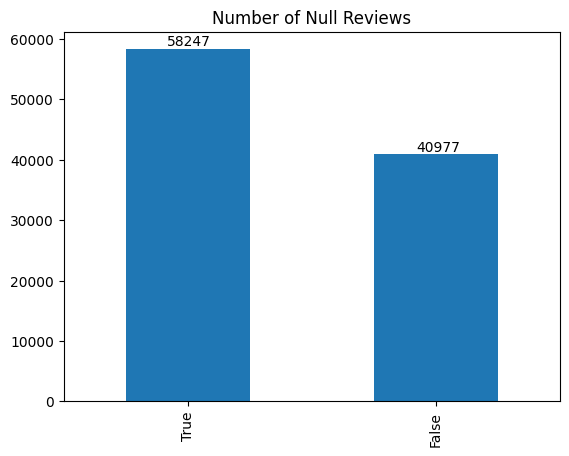

In [8]:
null_reviews = reviews.review_comment_message.isnull().value_counts()
ax = null_reviews.plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + (p.get_width()/3), p.get_height() * 1.01))
plt.title("Number of Null Reviews")
plt.show()

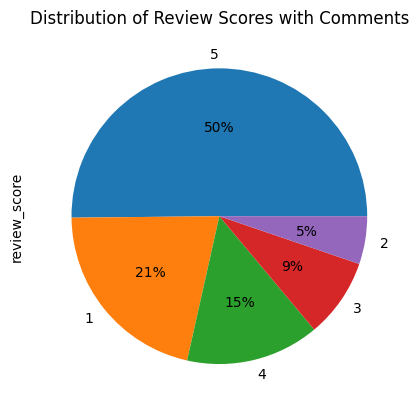

In [9]:
review_no_null = reviews[reviews.review_comment_message.notnull()==True]
review_score = review_no_null.review_score.value_counts()
review_score.plot.pie(y="review_score", autopct="%1.0f%%")
plt.title("Distribution of Review Scores with Comments")
plt.show()

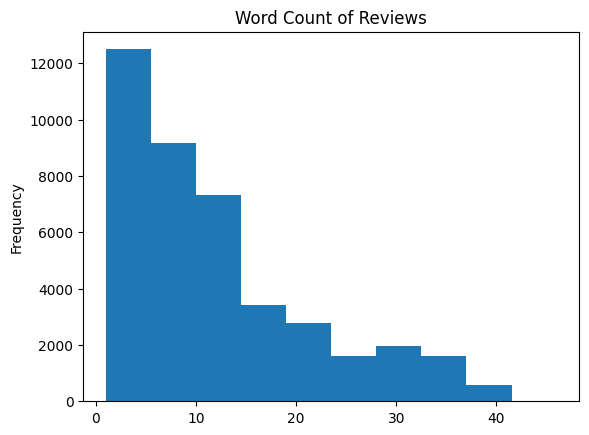

In [10]:
review_no_null.review_comment_message.map(lambda x: len(x.split(" "))).plot.hist(bins=10)
plt.title("Word Count of Reviews")
plt.show()

## 3. Preprocessing Data

### 3.1 Remove Missing Reviews

In [11]:
reviews = reviews.dropna(subset="review_comment_message")
reviews = reviews[["review_comment_message", "review_score"]].reset_index(drop=True)
reviews

,review_comment_message,review_score
0,Recebi bem antes do prazo estipulado.,5
1,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Pá...,5
2,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta...,4
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
4,"Vendedor confiável, produto ok e entrega antes do prazo.",5
...,...,...
40972,para este produto recebi de acordo com a compra realizada!,4
40973,Entregou dentro do prazo. O produto chegou em condições perfeitas. Estou muito satisfeita!,5
40974,"O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio ...",3
40975,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",5


### 3.2 Transfrom DataFrame for Deep Learning

In [12]:
# Creating labels that classify between a 5-star and not a 5-star review
reviews["labels"] = (reviews["review_score"] == 5).astype("int")
reviews = reviews.rename(columns={"review_comment_message": "features"})
reviews = reviews[["features", "labels"]]
reviews

,features,labels
0,Recebi bem antes do prazo estipulado.,1
1,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Pá...,1
2,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta...,0
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",0
4,"Vendedor confiável, produto ok e entrega antes do prazo.",1
...,...,...
40972,para este produto recebi de acordo com a compra realizada!,0
40973,Entregou dentro do prazo. O produto chegou em condições perfeitas. Estou muito satisfeita!,1
40974,"O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio ...",0
40975,"Excelente mochila, entrega super rápida. Super recomendo essa loja!",1


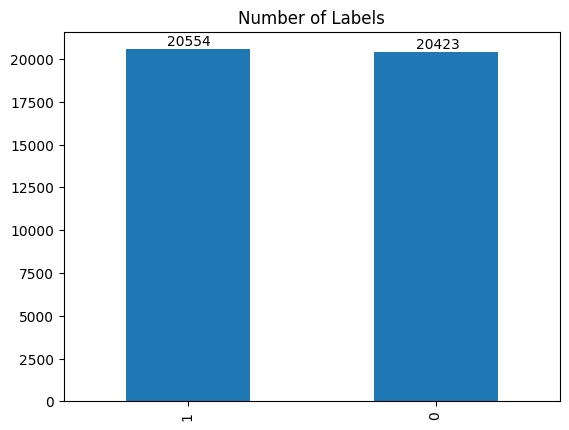

In [13]:
review_labels = reviews.labels.value_counts()
ax = review_labels.plot.bar()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005 + (p.get_width()/3), p.get_height() * 1.01))
plt.title("Number of Labels")
plt.show()

### 3.3 Split between Train and Test Data

In [14]:
# assign variables to features and labels
features, labels = reviews.features, reviews.labels

# use sklearn to split train and test data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels,
    train_size = TRAIN_SIZE,
    test_size = TEST_SIZE,
    random_state = SEED,
    shuffle = True,
    stratify = labels
)

In [15]:
train_features.head()

29709    O produto apresentou problema no cabo de alimentação de energia, o mesmo liga e desliga diversas...
29744    Comprei um produto e empresa enviou outro similar e mais barato. Entrei em contato e não respond...
21805    o produto não tem o marcador que acusa quando o filtro precisa ser trocado, somente isso, o prod...
12775                                                  RECEBI SOMENTE 4 TONNER 78 E NAO 10 COMO FOI COMPRADO
40913                                                             Produto ainda não chegou, estou no aguardo
Name: features, dtype: object

In [16]:
train_labels.head()

29709    0
29744    0
21805    0
12775    0
40913    0
Name: labels, dtype: int64

### 3.4 Convert to TensorFlow Datasets

In [17]:
# train X & y
X_train_raw = tf.data.Dataset.from_tensor_slices(
    tf.cast(train_features.values, tf.string)
)

y_train_raw = tf.data.Dataset.from_tensor_slices(
    tf.cast(train_labels.values, tf.int64)
)

# test X & y
X_test_raw = tf.data.Dataset.from_tensor_slices(
    tf.cast(test_features.values, tf.string)
)

y_test_raw = tf.data.Dataset.from_tensor_slices(
    tf.cast(test_labels.values, tf.int64)
)

### 3.5 Apply TextVectorization

### 3.5.1 Inspect the texts

In [18]:
inspect_list = ["\r\n",     # new lines
                "http",     # links
                "\d",       # numerals
                "👍"]       # like emoji

revs = [reviews[reviews.features.str.contains(regex)].count() for regex in inspect_list]
for index, rev in enumerate(revs):
    print("Number of reviews with", f'"{inspect_list[index]}"', ":")
    print(rev, end="\n\n")

Number of reviews with "
" :
features    3852
labels      3852
dtype: int64

Number of reviews with "http" :
features    1
labels      1
dtype: int64

Number of reviews with "\d" :
features    4117
labels      4117
dtype: int64

Number of reviews with "👍" :
features    56
labels      56
dtype: int64



### 3.5.2 Create custom standardization functions (cs)

In [19]:
emojis = ["👍","🤔","😎","😃","😁","💖","👏","👌","😍","👎","😀","😡","😊","😉","😘"," 🏻"," 🏼", " 🏽", " 🏾"]

__WITHOUT STOPWORDS__

In [20]:
def cs_no_stopword(input_data):
    no_lowercase = tf.strings.lower(input_data)
    no_new_line = tf.strings.regex_replace(no_lowercase, "\r\n", " ")
    no_number = tf.strings.regex_replace(no_new_line, "\d", " ")
    no_punctuation = tf.strings.regex_replace(no_number, f"[{re.escape(string.punctuation)}]", "")
    
    normal_a = tf.strings.regex_replace(no_punctuation, "[À,Ã,Â,Á,à,ã,â,á]", "a")
    normal_e = tf.strings.regex_replace(normal_a, "[É,Ê,é,ê]", "e")
    normal_i = tf.strings.regex_replace(normal_e, "[Í,í]", "i")
    normal_o = tf.strings.regex_replace(normal_i, "[Ó,Õ,Ô,ó,õ,ô]", "o")
    normal_u = tf.strings.regex_replace(normal_o, "[Ü,ü,ú]", "u")
    normal_c = tf.strings.regex_replace(normal_u, "[Ç,ç]", "c")
    
    no_emoji = normal_c
    for emoji in emojis:
        no_emoji = tf.strings.regex_replace(no_emoji, f"{emoji[0]}", " ")
        
    no_letters = tf.strings.regex_replace(no_emoji, " [a-z] ", "")
    no_letters = tf.strings.regex_replace(no_letters, "^[a-z] ", "")
    no_letters = tf.strings.regex_replace(no_letters, " [a-z]$", "")
    
    no_extra_space = tf.strings.regex_replace(no_letters, " +", " ")
    return no_extra_space

__WITH STOPWORDS__

In [21]:
stopwords_pt = pd.read_csv("../stopwords/stopwords-pt.txt", header=None)
stopwords_pt = stopwords_pt.squeeze()

stopwords_pt = stopwords_pt.map(lambda x: re.sub(r"[à,ã,â,á]", "a", x))
stopwords_pt = stopwords_pt.map(lambda x: re.sub(r"[é,ê]", "e", x))
stopwords_pt = stopwords_pt.map(lambda x: re.sub(r"[í]", "i", x))
stopwords_pt = stopwords_pt.map(lambda x: re.sub(r"[ó,õ,ô]", "o", x))
stopwords_pt = stopwords_pt.map(lambda x: re.sub(r"[ü,ú]", "u", x))
stopwords_pt = stopwords_pt.map(lambda x: re.sub(r"[ç]", "c", x))
stopwords_pt = stopwords_pt.to_frame()

In [22]:
def cs_with_stopword(input_data):
    no_lowercase = tf.strings.lower(input_data)
    no_new_line = tf.strings.regex_replace(no_lowercase, "\r\n", " ")
    no_number = tf.strings.regex_replace(no_new_line, "\d", " ")
    no_punctuation = tf.strings.regex_replace(no_number, f"[{re.escape(string.punctuation)}]", "")
    
    normal_a = tf.strings.regex_replace(no_punctuation, "[À,Ã,Â,Á,à,ã,â,á]", "a")
    normal_e = tf.strings.regex_replace(normal_a, "[É,Ê,é,ê]", "e")
    normal_i = tf.strings.regex_replace(normal_e, "[Í,í]", "i")
    normal_o = tf.strings.regex_replace(normal_i, "[Ó,Õ,Ô,ó,õ,ô]", "o")
    normal_u = tf.strings.regex_replace(normal_o, "[Ü,ü,ú]", "u")
    normal_c = tf.strings.regex_replace(normal_u, "[Ç,ç]", "c")
    
    no_emoji = normal_c
    for emoji in emojis:
        no_emoji = tf.strings.regex_replace(no_emoji, f"{emoji[0]}", " ")
        
    no_stopword = no_emoji
    for each in stopwords_pt.values:
        no_stopword = tf.strings.regex_replace(no_stopword, f" {each[0]} ", " ")
        no_stopword = tf.strings.regex_replace(no_stopword, f"^{each[0]} ", "")
        
    no_letters = tf.strings.regex_replace(no_stopword, " [a-z] ", "")
    no_letters = tf.strings.regex_replace(no_letters, "^[a-z] ", "")
    no_letters = tf.strings.regex_replace(no_letters, " [a-z]$", "")
    
    no_extra_space = tf.strings.regex_replace(no_letters, " +", " ")
    return no_extra_space

### 3.5.3 Test the functions

In [23]:
input_string = "Hello Par-aGRapH!\r\n  23   ... penguins, 100.50dollars x :) https://github.com/predbrad/bootcamp <3👍"
print("input:", input_string, end="\n\n")
output_string = cs_no_stopword(input_string)
print("output:", output_string.numpy().decode("utf-8"))

input: Hello Par-aGRapH!
  23   ... penguins, 100.50dollars x :) https://github.com/predbrad/bootcamp <3👍

output: hello paragraph penguins dollars httpsgithubcompredbradbootcamp 


In [24]:
input_string = "O produto apresentou problema no cabo de alimentação de energia, o mesmo liga e desliga diversas vezes durante o uso, nem pudemos testar ele na verdade, optamos por devolvê-lo, infelizmente!"
print("input:\n", input_string, end="\n\n")
output_string_1 = cs_no_stopword(input_string)
print("output without stopwords:\n", output_string_1.numpy().decode("utf-8"), end="\n\n")
output_string_2 = cs_with_stopword(input_string)
print("output with stopwords:\n", output_string_2.numpy().decode("utf-8"))

input:
 O produto apresentou problema no cabo de alimentação de energia, o mesmo liga e desliga diversas vezes durante o uso, nem pudemos testar ele na verdade, optamos por devolvê-lo, infelizmente!

output without stopwords:
 produto apresentou problema no cabo de alimentacao de energiamesmo ligadesliga diversas vezes duranteuso nem pudemos testar ele na verdade optamos por devolvelo infelizmente

output with stopwords:
 produto apresentou problema cabo alimentacao energia liga desliga uso pudemos testar optamos devolvelo infelizmente


### 3.5.4 Vectorize the texts

In [25]:
vectorize_layer = layers.TextVectorization(
    standardize=cs_with_stopword,
    max_tokens=VOCAB_SIZE+2,     # added two tokens for padding and unknown characters
    ngrams=NGRAMS,
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

In [26]:
vectorize_layer.adapt(X_train_raw)
vocab = vectorize_layer.get_vocabulary()

### 3.5.5 Check vectorized texts

In [27]:
print("Vocabulary has", len(vocab), "entries")
print("Vocabulary has the following first 20 entries:")
for word in range(20):
    print(word, "represents the word: ", vocab[word])

Vocabulary has 5002 entries
Vocabulary has the following first 20 entries:
0 represents the word:  
1 represents the word:  [UNK]
2 represents the word:  produto
3 represents the word:  prazo
4 represents the word:  entrega
5 represents the word:  chegou
6 represents the word:  recebi
7 represents the word:  recomendo
8 represents the word:  entregue
9 represents the word:  veio
10 represents the word:  qualidade
11 represents the word:  comprei
12 represents the word:  otimo
13 represents the word:  loja
14 represents the word:  compra
15 represents the word:  gostei
16 represents the word:  excelente
17 represents the word:  super
18 represents the word:  rapida
19 represents the word:  bom


In [28]:
for X in train_features.iloc[:2]:
    print("Given raw data: ")
    print(X, end="\n\n")
    
    tokenized = vectorize_layer(tf.expand_dims(X, -1))
    print("Tokenized and Transformed to a vector of integers: ")
    print(tokenized, end="\n\n")
    
    print("Text after Tokenized and Transformed: ")
    transformed = ""
    for each in tf.squeeze(tokenized):
        transformed = transformed + " " + vocab[each]
    print(transformed, end="\n\n")

Given raw data: 
O produto apresentou problema no cabo de alimentação de energia, o mesmo liga e desliga diversas vezes durante o uso, nem pudemos testar ele na verdade, optamos por devolvê-lo, infelizmente!

Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[   2  896   43  295 4211 1265  652 3229  185    1  428    1 1619  172
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]], shape=(1, 50), dtype=int64)

Text after Tokenized and Transformed: 
 produto apresentou problema cabo alimentacao energia liga desliga uso [UNK] testar [UNK] devolvelo infelizmente                                    

Given raw data: 
Comprei um produto e empresa enviou outro similar e mais barato. Entrei em contato e não responderam nada sobre a divergência.

Tokenized and Transformed to a vector of integers: 
tf.Tensor(
[[  11    2   55  395  842  389  261   49

In [29]:
def vectorize_text(feature):
  text = tf.expand_dims(feature, -1)
  return tf.squeeze(vectorize_layer(text))

In [30]:
# X Train
X_train = X_train_raw.map(vectorize_text, num_parallel_calls=AUTOTUNE)

# X Test
X_test = X_test_raw.map(vectorize_text, num_parallel_calls=AUTOTUNE)

In [31]:
for each in X_train.take(1):
    print(each)

tf.Tensor(
[   2  896   43  295 4211 1265  652 3229  185    1  428    1 1619  172
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


### 3.5.6 Combine features and labels

In [32]:
train_ds = tf.data.Dataset.zip((X_train, y_train_raw))
test_ds = tf.data.Dataset.zip((X_test, y_test_raw))

In [33]:
id_to_category = ["not 5-star", "5-star"]

for X, y in train_ds.take(1):
    print("Feature shape:", X.shape, end="\n\n")
    print("Label shape:", y.shape, end="\n\n")
    print("Feature(int):", X, end="\n\n")
    print("Label(int):", y, end="\n\n")
    feature_t = " ".join([vocab[x] for x in tf.squeeze(X)])
    label_t = id_to_category[y.numpy()]
    print("Feature(text):", feature_t, end="\n\n")
    print("Label(text):", label_t)

Feature shape: (50,)

Label shape: ()

Feature(int): tf.Tensor(
[   2  896   43  295 4211 1265  652 3229  185    1  428    1 1619  172
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)

Label(int): tf.Tensor(0, shape=(), dtype=int64)

Feature(text): produto apresentou problema cabo alimentacao energia liga desliga uso [UNK] testar [UNK] devolvelo infelizmente                                    

Label(text): not 5-star


## 4. Build the model

### 4.1 Set dataset parameters

In [34]:
# BUFFER_SIZE = train_ds.cardinality().numpy()

train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)\
                 .cache()\
                 .prefetch(AUTOTUNE)

### 4.2 Set model parameters

In [35]:
model = tf.keras.Sequential([
  layers.Embedding(VOCAB_SIZE + 2, EMBEDDING_DIM),
  layers.Dropout(0.1),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.1),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320128    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 320,193
Trainable params: 320,193
Non-trainable params: 0
__________________________________________________

### 4.3 Compile the model

In [36]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### 4.4 Train the model

In [37]:
history = model.fit(
    train_ds,
    epochs=EPOCHS)

Epoch 1/10
512/512 [==============================] - 7s 12ms/step - loss: 0.6317 - binary_accuracy: 0.6937
Epoch 2/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4985 - binary_accuracy: 0.7874
Epoch 3/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4540 - binary_accuracy: 0.8061
Epoch 4/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4361 - binary_accuracy: 0.8148
Epoch 5/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4250 - binary_accuracy: 0.8204
Epoch 6/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4178 - binary_accuracy: 0.8245
Epoch 7/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4115 - binary_accuracy: 0.8264
Epoch 8/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4061 - binary_accuracy: 0.8286
Epoch 9/10
512/512 [==============================] - 2s 4ms/step - loss: 0.4016 - binary_accuracy: 0.8300
Epoch 10/10
512/512 [===============

### 4.5 Evaluate the model

In [38]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

128/128 [==============================] - 2s 14ms/step - loss: 0.4332 - binary_accuracy: 0.8142
Loss:  0.43324947357177734
Accuracy:  0.814208984375


### 4.6 Test the model

In [39]:
y_pred = model.predict(test_ds)
y_pred = [1 if pred > 0 else 0 for pred in y_pred]
y_pred = tf.convert_to_tensor(y_pred, dtype="int64")
y_pred

128/128 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(8192,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 0, 1])>

In [40]:
y_true = tf.concat(list(test_ds.map(lambda X,y: y)), axis=0)
y_true

<tf.Tensor: shape=(8192,), dtype=int64, numpy=array([0, 1, 1, ..., 1, 1, 1])>

### 4.7 Show models' metrics

__CONFUSION MATRIX__

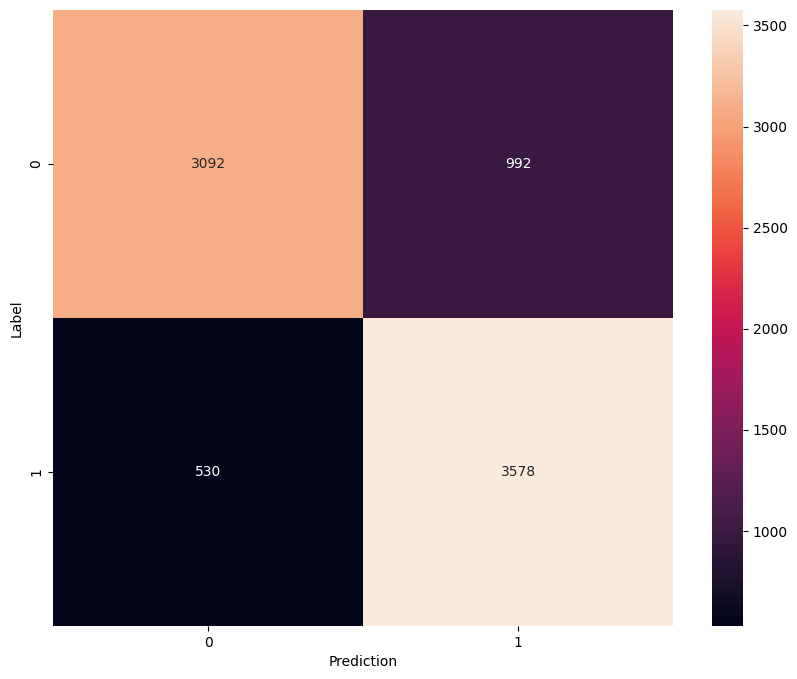

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

__PRECISION__

In [42]:
m = tf.keras.metrics.Precision(thresholds=0)
m.update_state(y_true, y_pred)
m.result().numpy()

0.78293216

__RECALL__

In [43]:
m = tf.keras.metrics.Recall(thresholds=0)
m.update_state(y_true, y_pred)
m.result().numpy()

0.8709834